In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm
import plotly.express as px

from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
def load_data(directory):
    data = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            data.append(df)
    return pd.concat(data, ignore_index=True)

df = load_data('data/cic')
# Clean column names (in case of whitespace)
df.columns = df.columns.str.strip()

df = df[df['Label'] != 'BENIGN']

features = df.select_dtypes(include=[np.number]).copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
df = df.loc[features.index].copy()

100%|██████████| 8/8 [00:15<00:00,  1.90s/it]


In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
df["Label"].value_counts()

Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [5]:
def group_attack_label(label):
    if label == "BENIGN":
        return "Benign"
    elif "DoS" in label or label == "DDoS":
        return "DoS/DDoS"
    elif "PortScan" in label:
        return "Scan"
    elif "Patator" in label:
        return "BruteForce"
    elif "Web Attack" in label:
        return "WebAttack"
    elif label in ["Bot", "Infiltration", "Heartbleed"]:
        return "Other"
    else:
        return "Unknown"

df['label_group'] = df['Label'].apply(group_attack_label)

In [6]:
df["label_group"].value_counts()

label_group
DoS/DDoS      379737
Scan          158804
BruteForce     13832
WebAttack       2180
Other           2003
Name: count, dtype: int64

In [7]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,label_group
0,80,1293792,3,7,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,DDoS,DoS/DDoS
1,80,4421382,4,0,24,0,6,6,6.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,DDoS,DoS/DDoS
2,80,1083538,3,6,26,11601,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,DDoS,DoS/DDoS
3,80,80034360,8,4,56,11601,20,0,7.000000,5.656854,...,939.0,0.0,939,939,39300000.0,44200000.0,70600000,8072664,DDoS,DoS/DDoS
4,80,642654,3,6,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,DDoS,DoS/DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556551,80,11512204,8,5,326,11632,326,0,40.750000,115.258405,...,892.0,0.0,892,892,6507197.0,0.0,6507197,6507197,DoS GoldenEye,DoS/DDoS
556552,80,11513325,5,5,471,3525,471,0,94.200000,210.637604,...,918.0,0.0,918,918,6508582.0,0.0,6508582,6508582,DoS GoldenEye,DoS/DDoS
556553,80,11509201,7,6,314,11632,314,0,44.857143,118.680845,...,899.0,0.0,899,899,6503248.0,0.0,6503248,6503248,DoS GoldenEye,DoS/DDoS
556554,80,11509095,8,5,369,11632,369,0,46.125000,130.461201,...,914.0,0.0,914,914,6504954.0,0.0,6504954,6504954,DoS GoldenEye,DoS/DDoS


In [8]:
df = df.loc[:, ~df.columns.str.contains('bwd', case=False)]
df = df.loc[:, ~df.columns.str.contains('backward', case=False)]


In [9]:
import pickle
with open('data/grouped_df.pkl', 'rb') as f:
    grouped_df = pickle.load(f)
grouped_df

,cic_Total Fwd Packets,cic_Total Length of Fwd Packets,cic_Fwd Packet Length Mean,cic_Fwd Packet Length Min,cic_Fwd Packet Length Max,cic_Fwd Packet Length Std,cic_Packet Length Variance,cic_Flow IAT Mean,cic_Flow IAT Std,cic_Flow IAT Min,...,dst_country_emb_1_first,dst_country_emb_2_first,dst_country_emb_3_first,dst_country_emb_4_first,dst_country_emb_5_first,dst_country_emb_6_first,dst_country_emb_7_first,dst_country_emb_8_first,dst_country_emb_9_first,cic_Fwd IAT Total
0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.112963,-0.001585,0.100905,-0.065801,0.297281,0.305936,-0.159620,0.116160,-0.044771,0
1,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,-0.004529,-0.047310,-0.011996,0.005260,-0.025826,-0.004693,0.013444,0.013675,-0.007392,0
2,3.0,239.0,79.666667,0.0,147.0,74.272023,5516.333333,1.0,1.732051,0.0,...,0.352385,-0.087578,0.331180,-0.106147,-0.040069,-0.212324,0.055434,0.027325,0.007878,3
3,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.112963,-0.001585,0.100905,-0.065801,0.297281,0.305936,-0.159620,0.116160,-0.044771,0
4,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.145555,-0.105995,-0.107222,0.117179,-0.348651,0.276392,0.075724,-0.134629,0.061312,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339707,1.0,133.0,133.000000,133.0,133.0,0.000000,0.000000,0.0,0.000000,0.0,...,-0.030979,0.040023,0.056062,0.007198,0.258058,0.090996,-0.054872,0.113645,-0.099819,0
339708,1.0,97.0,97.000000,97.0,97.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.352385,-0.087578,0.331180,-0.106147,-0.040069,-0.212324,0.055434,0.027325,0.007878,0
339709,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,-0.147976,0.098074,0.063331,-0.045459,-0.107533,-0.084309,-0.155936,-0.095196,-0.385889,0
339710,1.0,22.0,22.000000,22.0,22.0,0.000000,0.000000,0.0,0.000000,0.0,...,-0.147976,0.098074,0.063331,-0.045459,-0.107533,-0.084309,-0.155936,-0.095196,-0.385889,0


In [10]:
cic_columns = grouped_df.filter(regex='^cic').columns
grouped_df = grouped_df[[col for col in grouped_df.columns if 'emb' not in col]]
grouped_df_cic = grouped_df[cic_columns]

In [11]:
import pandas as pd

# Assuming your DataFrame is called 'grouped_df'
# Assuming your mapping list is called 'feature_mapping'

feature_mapping = [
    ('Destination Port', 'cic_Destination Port'),
    ('Flow Duration', 'cic_Flow Duration'),
    ('Total Fwd Packets', 'cic_Total Fwd Packets'),
    ('Total Length of Fwd Packets', 'cic_Total Length of Fwd Packets'),
    ('Fwd Packet Length Max', 'cic_Fwd Packet Length Max'),
    ('Fwd Packet Length Min', 'cic_Fwd Packet Length Min'),
    ('Fwd Packet Length Mean', 'cic_Fwd Packet Length Mean'),
    ('Fwd Packet Length Std', 'cic_Fwd Packet Length Std'),
    ('Flow Bytes/s', 'cic_Flow Bytes/s'),
    ('Flow Packets/s', 'cic_Flow Packets/s'),
    ('Flow IAT Mean', 'cic_Flow IAT Mean'),
    ('Flow IAT Std', 'cic_Flow IAT Std'),
    ('Flow IAT Max', 'cic_Flow IAT Max'),
    ('Flow IAT Min', 'cic_Flow IAT Min'),
    ('Fwd IAT Total', 'cic_Fwd IAT Total'),
    ('Fwd IAT Mean', 'cic_Fwd IAT Mean'),
    ('Fwd IAT Std', 'cic_Fwd IAT Std'),
    ('Fwd IAT Max', 'cic_Fwd IAT Max'),
    ('Fwd IAT Min', 'cic_Fwd IAT Min'),
    ('Fwd Packets/s', 'cic_Fwd Packets/s'),
    ('Min Packet Length', 'cic_Min Packet Length'),
    ('Max Packet Length', 'cic_Max Packet Length'),
    ('Packet Length Mean', 'cic_Packet Length Mean'),
    ('Packet Length Std', 'cic_Packet Length Std'),
    ('Packet Length Variance', 'cic_Packet Length Variance'),
    ('Average Packet Size', 'cic_Average Packet Size'),
    ('Avg Fwd Segment Size', 'cic_Avg Fwd Segment Size')
]

rename_dict = {cic_name: new_name for new_name, cic_name in feature_mapping}
grouped_df_cic.rename(columns=rename_dict, inplace=True)

C:\Users\lucch\AppData\Local\Temp\ipykernel_15012\2118983607.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.rename(columns=rename_dict, inplace=True)


In [12]:
columns = list(grouped_df_cic.columns)
columns.append("label_group")

In [13]:
df = df[columns]
df

,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Max,Fwd Packet Length Std,Packet Length Variance,Flow IAT Mean,Flow IAT Std,Flow IAT Min,...,Packet Length Mean,Packet Length Std,Average Packet Size,Avg Fwd Segment Size,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Fwd IAT Total,label_group
0,3,26,8.666667,0,20,10.263203,3.435231e+06,1.437547e+05,4.308658e+05,2,...,1057.545455,1853.437529,1163.300000,8.666667,3.735000e+02,5.239661e+02,744,3,747,DoS/DDoS
1,4,24,6.000000,6,6,0.000000,0.000000e+00,1.473794e+06,2.552043e+06,340,...,6.000000,0.000000,7.500000,6.000000,1.473794e+06,2.552043e+06,4420639,340,4421382,DoS/DDoS
2,3,26,8.666667,0,20,10.263203,2.706820e+06,1.354422e+05,3.777253e+05,41,...,1162.700000,1645.241762,1291.888889,8.666667,6.491000e+03,8.165669e+03,12265,717,12982,DoS/DDoS
3,8,56,7.000000,0,20,5.656854,6.192667e+06,7.275851e+06,2.110000e+07,6,...,897.153846,2488.507044,971.916667,7.000000,1.120000e+07,2.630000e+07,70600000,247,78700000,DoS/DDoS
4,3,26,8.666667,0,20,10.263203,4.572452e+06,8.033175e+04,2.268247e+05,3,...,1163.300000,2138.329153,1292.555556,8.666667,4.005000e+02,5.409367e+02,783,18,801,DoS/DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556551,8,326,40.750000,0,326,115.258405,7.361769e+06,9.593503e+05,2.262616e+06,1,...,854.142857,2713.257986,919.846154,40.750000,9.301100e+05,2.460477e+06,6509948,1,6510770,DoS/DDoS
556552,5,471,94.200000,0,471,210.637604,5.180836e+05,1.279258e+06,2.565153e+06,53,...,363.272727,719.780257,399.600000,94.200000,1.628158e+06,3.255639e+06,6511616,176,6512631,DoS/DDoS
556553,7,314,44.857143,0,314,118.680845,3.449144e+06,9.591001e+05,2.261842e+06,46,...,853.285714,1857.187221,918.923077,44.857143,1.084509e+06,2.655701e+06,6505437,255,6507056,DoS/DDoS
556554,8,369,46.125000,0,369,130.461201,7.358407e+06,9.590912e+05,2.262122e+06,47,...,857.214286,2712.638403,923.153846,46.125000,9.296849e+05,2.458891e+06,6505926,168,6507794,DoS/DDoS


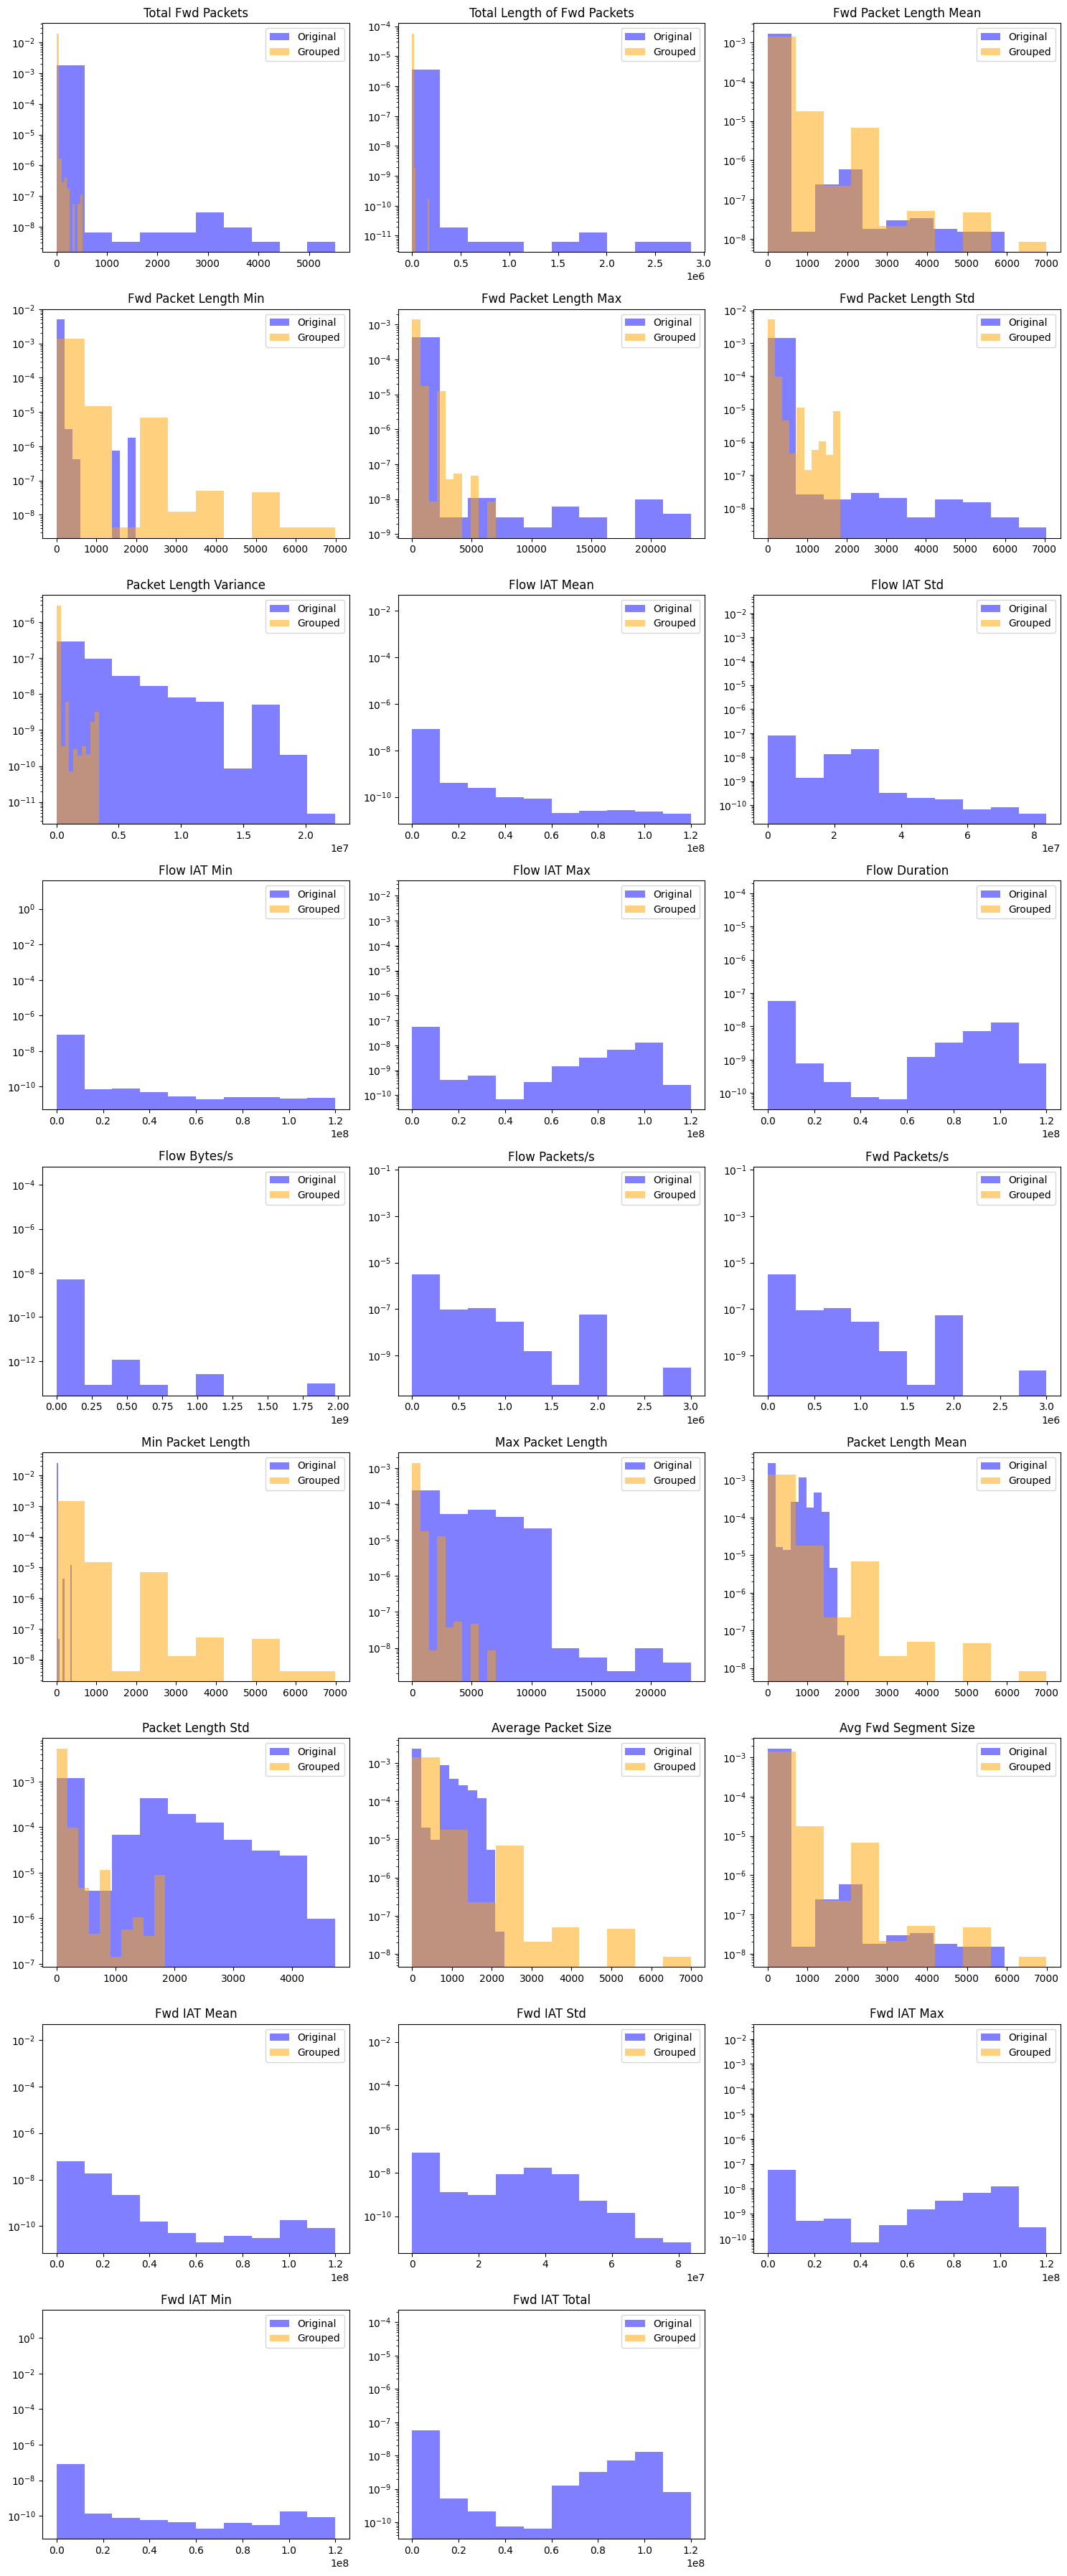

In [14]:
features = grouped_df_cic.select_dtypes(include='number').columns
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[feature], bins=10, alpha=0.5, label='Original', color='blue', density=True)
    plt.hist(grouped_df_cic[feature], bins=10, alpha=0.5, label='Grouped', color='orange', density=True)
    plt.title(feature)
    plt.legend()
    plt.yscale('log')


plt.tight_layout()
plt.show()

In [15]:
grouped_df_cic.describe()

,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Max,Fwd Packet Length Std,Packet Length Variance,Flow IAT Mean,Flow IAT Std,Flow IAT Min,...,Max Packet Length,Packet Length Mean,Packet Length Std,Average Packet Size,Avg Fwd Segment Size,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Fwd IAT Total
count,339712.000000,339712.000000,339712.000000,339712.000000,339712.000000,339712.000000,3.397120e+05,339712.000000,339712.000000,339712.0,...,339712.000000,339712.000000,339712.000000,339712.000000,339712.000000,339712.000000,339712.000000,339712.000000,339712.0,339712.000000
mean,1.987222,242.907133,108.690773,86.289395,135.994116,25.806694,1.008403e+04,8.564092,10.940064,0.0,...,135.994116,108.690773,25.806694,108.690773,108.690773,8.564092,10.940064,20.435751,0.0,39.028156
std,2.975925,781.750174,237.820966,229.802586,284.072214,97.046763,1.353130e+05,36.784266,43.622244,0.0,...,284.072214,237.820966,97.046763,237.820966,237.820966,36.784266,43.622244,79.038769,0.0,451.200207
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.000000,45.000000,28.000000,12.000000,32.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,...,32.000000,28.000000,0.000000,28.000000,28.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,2.000000,239.000000,85.500000,54.000000,147.000000,1.000000,1.000000e+00,0.500000,0.577350,0.0,...,147.000000,85.500000,1.000000,85.500000,85.500000,0.500000,0.577350,1.000000,0.0,2.000000
max,518.000000,175838.000000,6995.500000,6995.000000,6996.000000,1840.598951,3.387804e+06,550.500000,424.264069,0.0,...,6996.000000,6995.500000,1840.598951,6995.500000,6995.500000,550.500000,424.264069,600.000000,0.0,86325.000000


# prepare the data 
- x_train x_test ect
- the omni dataset to make predictions on

In [16]:
le = LabelEncoder()

df['label_group_encoded'] = le.fit_transform(df['label_group'])
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")
print("\nUnique encoded values:", df['label_group_encoded'].unique())
print("Original labels:", df['label_group'].unique())
df.drop(columns=["label_group"], inplace=True)

BruteForce: 0
DoS/DDoS: 1
Other: 2
Scan: 3
WebAttack: 4

Unique encoded values: [1 3 2 4 0]
Original labels: ['DoS/DDoS' 'Scan' 'Other' 'WebAttack' 'BruteForce']


In [17]:
x = df.drop(columns=["label_group_encoded"])
y = df["label_group_encoded"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
x_grouped = grouped_df_cic.copy()

scaler = QuantileTransformer()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_grouped = pd.DataFrame(scaler.transform(x_grouped), columns=x.columns)

# random forest model

In [18]:
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
rf.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2849
           1       1.00      1.00      1.00     75926
           2       0.99      0.99      0.99       432
           3       1.00      1.00      1.00     31656
           4       0.92      0.94      0.93       449

    accuracy                           1.00    111312
   macro avg       0.98      0.98      0.98    111312
weighted avg       1.00      1.00      1.00    111312



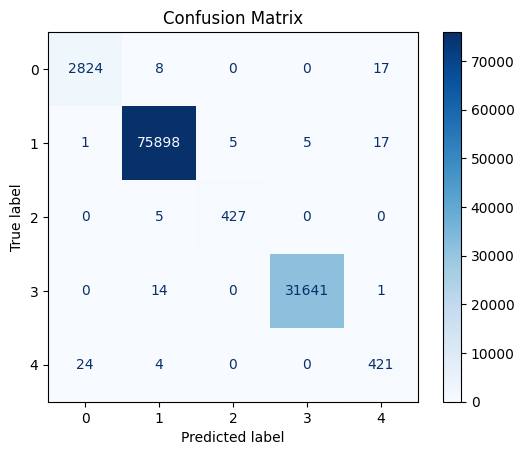

In [19]:
pred = rf.predict(x_test)
omni_pred = rf.predict(x_grouped)

print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [20]:
pd.Series(omni_pred).value_counts()

1    248906
0     90806
Name: count, dtype: int64

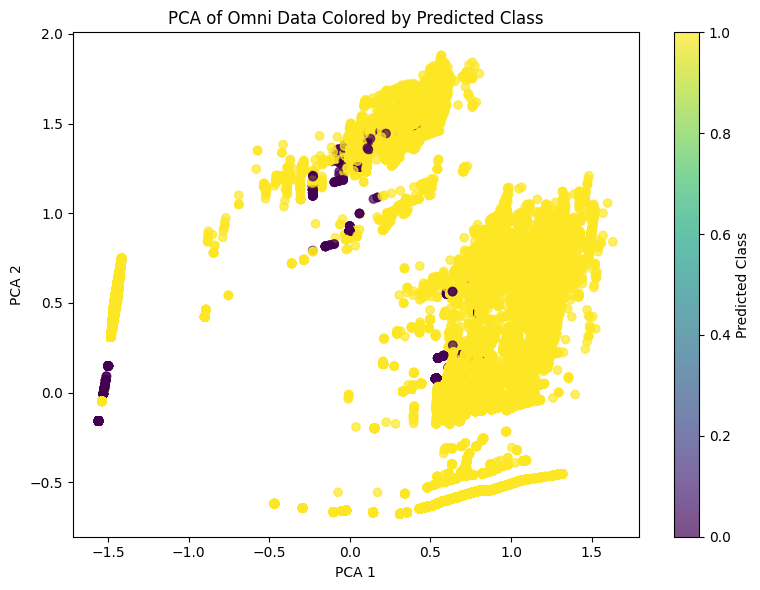

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_grouped)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

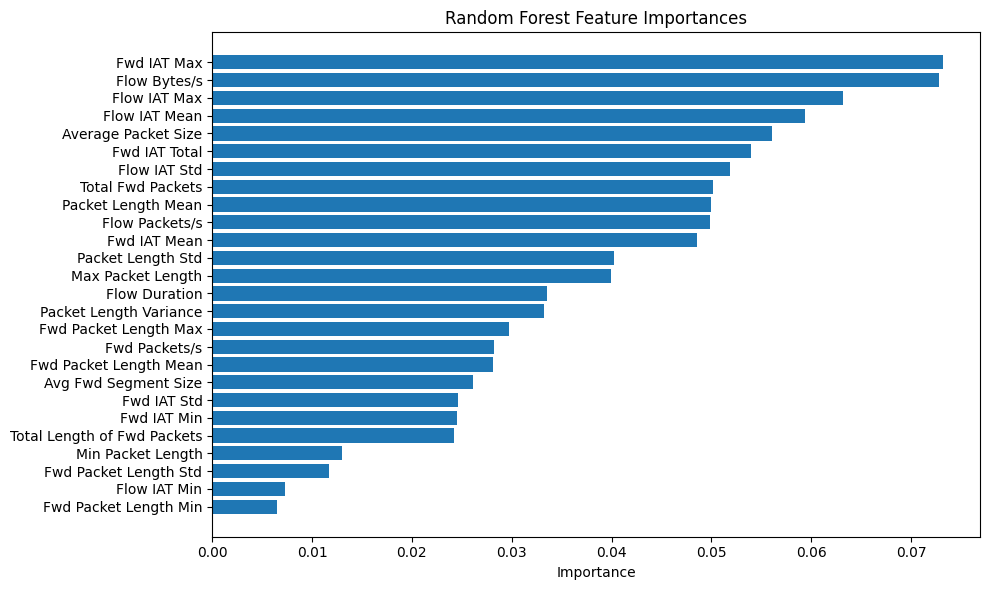

In [22]:
importances = rf.feature_importances_
feature_names = x.columns

# Create a DataFrame for better visualization
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# neural network

In [23]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Add
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint


In [24]:
class F1ScoreCallback(Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.x_val)
        y_pred = np.argmax(y_pred_probs, axis=1)
        f1 = f1_score(self.y_val, y_pred, average='macro')  # or 'weighted'
        print(f"\nEpoch {epoch+1}: F1 Score = {f1:.4f}")


inp = Input(shape=(x_train.shape[1],))
x1 = Dense(256)(inp)
x1 = BatchNormalization()(x1)
x1 = tf.keras.activations.relu(x1)

x2 = Dense(128)(x1)
x2 = BatchNormalization()(x2)
x2 = tf.keras.activations.relu(x2)

encoded = Dense(32)(x2)
encoded = BatchNormalization()(encoded)
encoded = tf.keras.activations.relu(encoded)

# Decoder
d1 = Dense(128)(encoded)
d1 = BatchNormalization()(d1)
d1 = tf.keras.activations.relu(d1)

d2 = Dense(256)(d1)
d2 = BatchNormalization()(d2)
d2 = tf.keras.activations.relu(d2)

decoded = Dense(x_train.shape[1])(d2)

residual_output = Add()([decoded, inp])

output = Dense(5, activation='softmax')(residual_output)

model = Model(inputs=inp, outputs=output)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      6,912 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      4,128 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      4,224 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     33,024 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 26)        │      6,682 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 26)        │          0 │ dense_5[0][0],    │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │        135 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,201 (356.25 KB)

 Trainable params: 89,601 (350.00 KB)

 Non-trainable params: 1,600 (6.25 KB)

In [27]:
f1_callback = F1ScoreCallback(x_val=x_test, y_val=y_test)
cp = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="loss",
    mode="min"
)

model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[f1_callback, cp])

Epoch 1/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step

Epoch 1: F1 Score = 0.9621
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.9905 - loss: 0.0338 - val_accuracy: 0.9973 - val_loss: 0.0114
Epoch 2/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 872us/step

Epoch 2: F1 Score = 0.9735
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9961 - loss: 0.0139 - val_accuracy: 0.9978 - val_loss: 0.0081
Epoch 3/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 864us/step

Epoch 3: F1 Score = 0.9741
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9971 - loss: 0.0104 - val_accuracy: 0.9981 - val_loss: 0.0080
Epoch 4/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 855us/step

Epoch 4: F1 Score = 0.9793
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9975 - loss: 0.0088 - val_accuracy: 0.9985 - val_loss: 0.0065
Epoch 5/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 869us/step

Epoch 5: F1 Score = 0.9843
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9978 - loss: 0.0085 - val_accura

In [25]:
from tensorflow.keras.models import load_model
model = load_model("best_model.keras")

In [26]:
pred_probs = model.predict(x_test)
pred = pred_probs.argmax(axis=1)

omni_probs = model.predict(x_grouped)
omni_pred = omni_probs.argmax(axis=1)

3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 859us/step
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 9s 824us/step


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2849
           1       1.00      1.00      1.00     75926
           2       0.99      0.99      0.99       432
           3       1.00      1.00      1.00     31656
           4       1.00      0.92      0.96       449

    accuracy                           1.00    111312
   macro avg       0.99      0.98      0.99    111312
weighted avg       1.00      1.00      1.00    111312



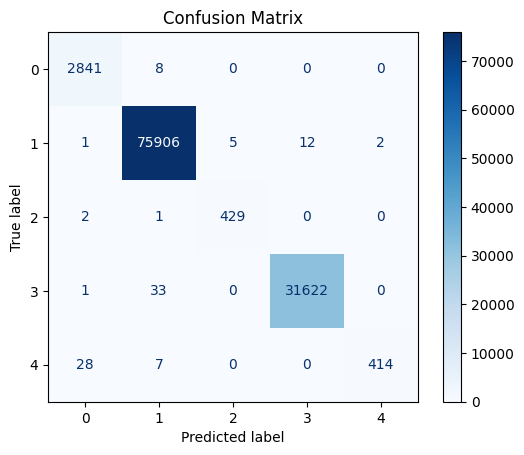

In [27]:
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [31]:
pd.Series(omni_pred).value_counts()

4    168265
1    134127
2     28127
0      8723
3       470
Name: count, dtype: int64

## PCA

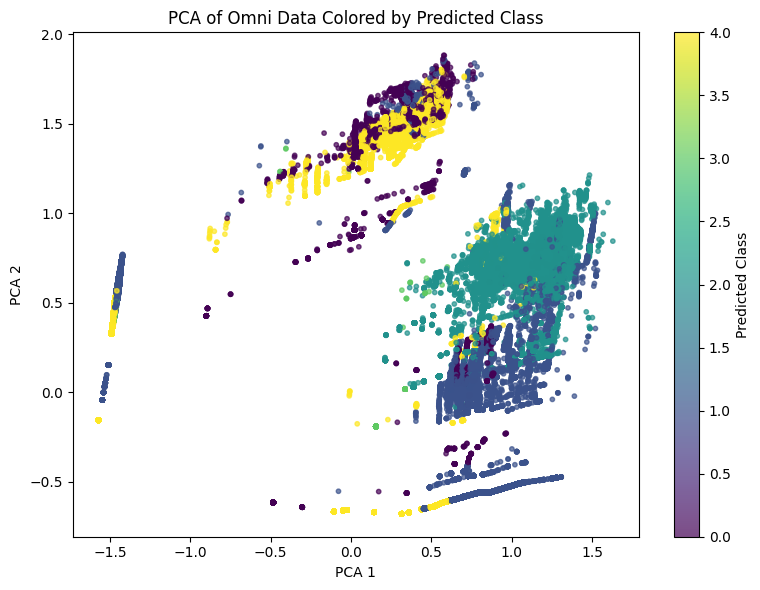

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

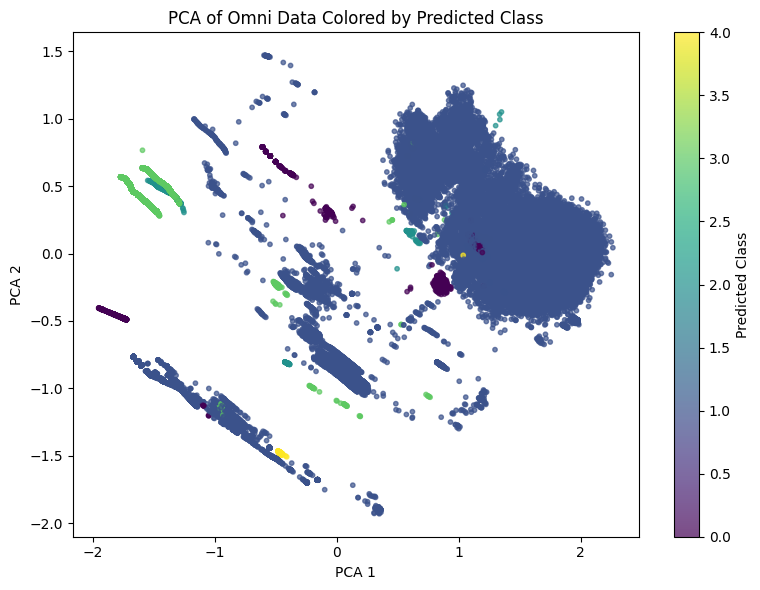

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

## umap

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

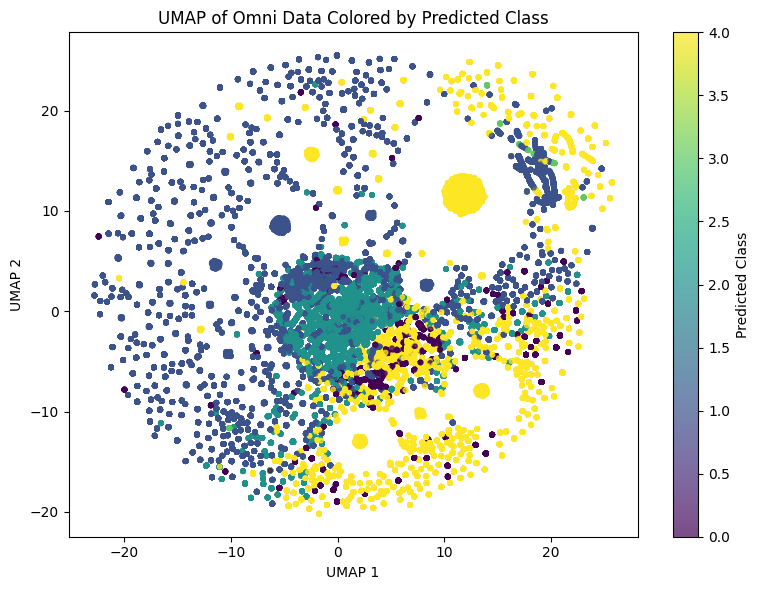

In [34]:
import umap
pca = umap.UMAP()
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=10)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


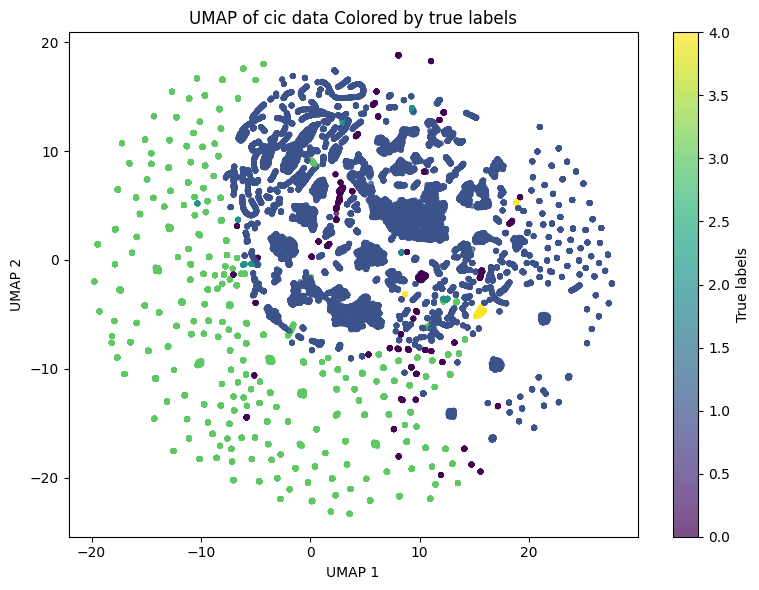

In [35]:
pca = umap.UMAP()
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=10)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of cic data Colored by true labels')
plt.colorbar(scatter, label='True labels')
plt.tight_layout()
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(4486, 26))
  warnings.warn(msg)
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(4486, 26))
  warnings.warn(msg)
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs

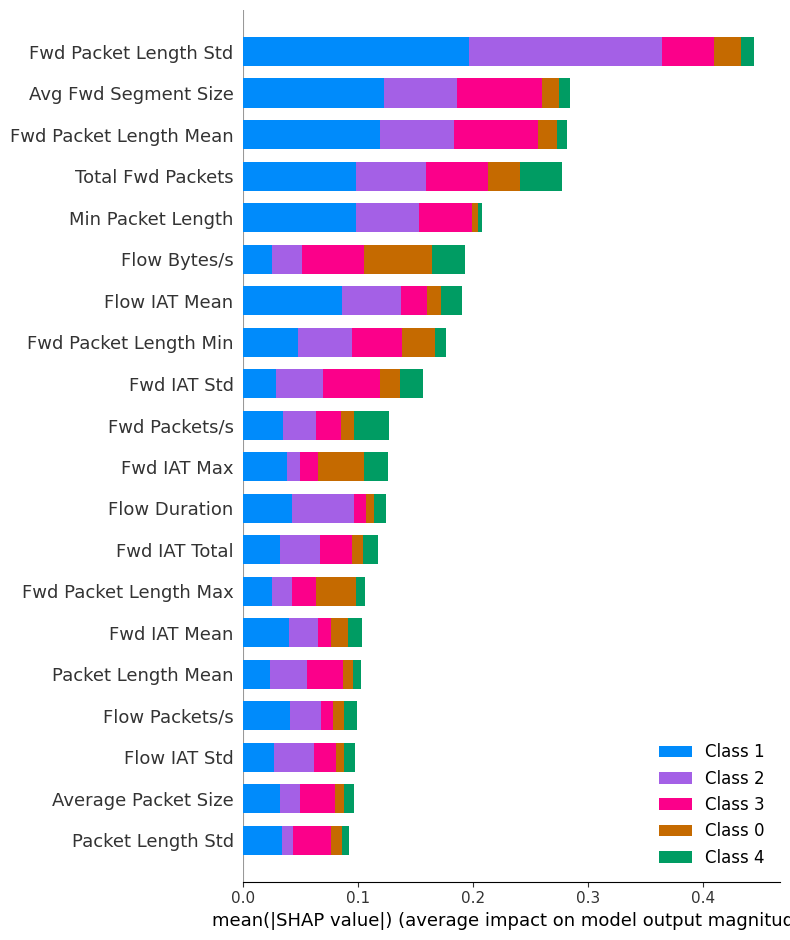

In [36]:
import shap

background = x_train.iloc[np.random.choice(x_train.shape[0], 100, replace=False)]

explainer = shap.Explainer(model, background)
shap_values = explainer(x_test[:200])

shap.summary_plot(shap_values, x_test[:200], feature_names=feature_names)

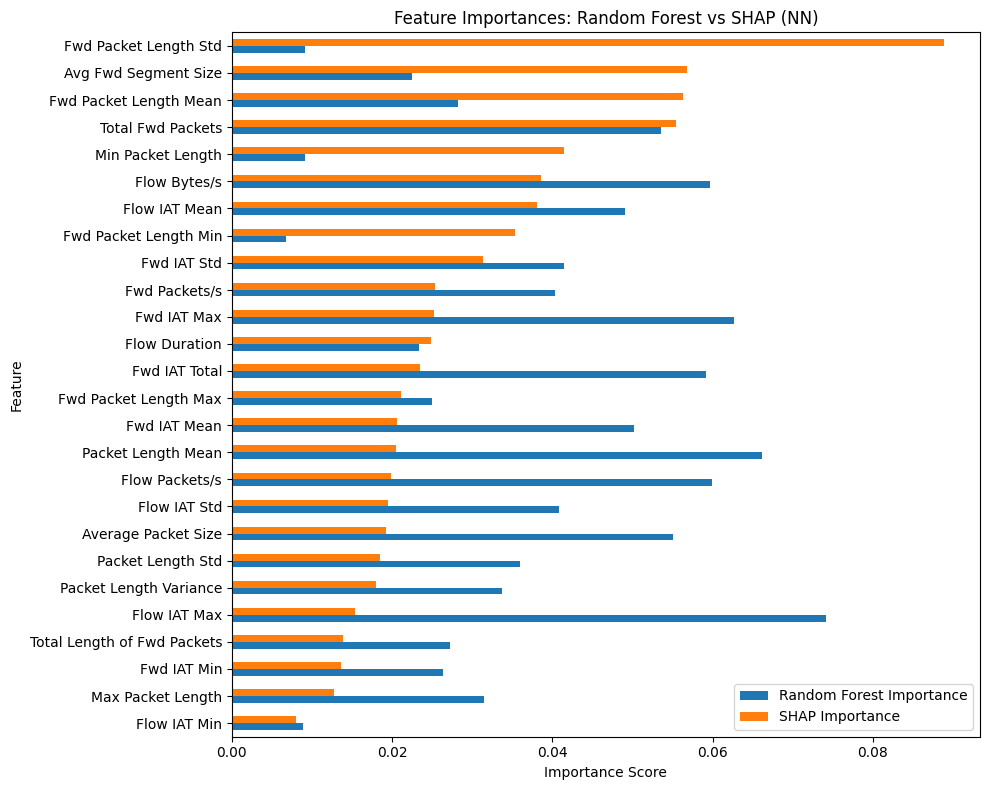

In [37]:
rf_importances = np.array(rf.feature_importances_).flatten()
shap_vals = shap_values.values  
shap_importance = np.abs(shap_vals).mean(axis=0).mean(axis=1)

assert len(rf_importances) == len(shap_importance) == x_train.shape[1]

# Create the comparison DataFrame
compare_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Random Forest Importance': rf_importances,
    'SHAP Importance': shap_importance
}).set_index('Feature')

# Sort and plot
compare_df = compare_df.sort_values('SHAP Importance', ascending=True)

compare_df.plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importances: Random Forest vs SHAP (NN)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


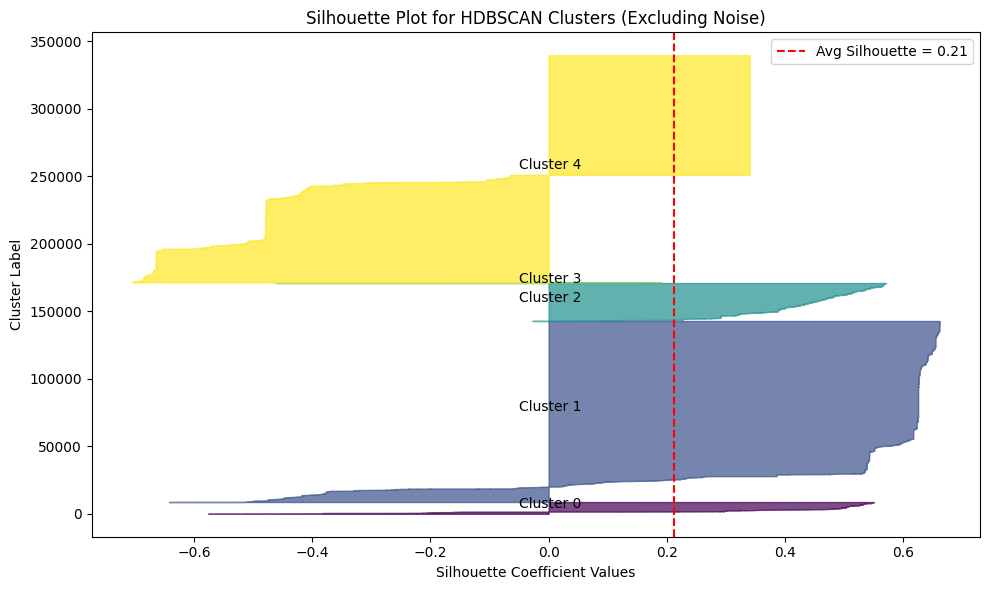

In [38]:
silhouette_vals = silhouette_samples(x_grouped, omni_pred)
avg_silhouette = sil_(x_grouped, omni_pred)

# Sort for better visualization
sorted_idx = np.argsort(omni_pred)
sorted_silhouette_vals = silhouette_vals[sorted_idx]
sorted_cluster_labels = omni_pred[sorted_idx]

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
unique_labels = np.unique(omni_pred)

for label in unique_labels:
    label_sil_vals = sorted_silhouette_vals[sorted_cluster_labels == label]
    label_sil_vals.sort()
    y_upper = y_lower + len(label_sil_vals)

    color = plt.cm.viridis(float(label) / (len(unique_labels) - 1))
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, label_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(label_sil_vals), f'Cluster {label}')
    y_lower = y_upper + 10

# Draw average silhouette score line
ax.axvline(avg_silhouette, color="red", linestyle="--", label=f"Avg Silhouette = {avg_silhouette:.2f}")
ax.set_title("Silhouette Plot for HDBSCAN Clusters (Excluding Noise)")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()

# here I want to make an analysis of the predictions based on the features especially teh commands that where extracted in the omni document

check if the predicted scan or ddos or other have commands that are expected os such attacks

In [40]:
df_analysis = grouped_df.copy()
df_analysis['predicted_label'] = omni_pred
cmd_cols = [col for col in df_analysis.columns if col.startswith('cmd_')]

# Get proportions per class
binary_feature_means = df_analysis.groupby('predicted_label')[cmd_cols].mean() *100

label_map = {
    0: 'BruteForce',
    1: 'DoS/DDoS',
    2: 'Other',
    3: 'Scan',
    4: 'WebAttack'
}

binary_feature_means = binary_feature_means.rename(index=label_map)

print(binary_feature_means.round(2))

                 cmd_wget_max  cmd_curl_max  cmd_chmod_max  cmd_dd_max  \
predicted_label                                                          
BruteForce               0.00          3.47           0.00        1.32   
DoS/DDoS                 0.20          0.41           0.16        0.37   
Other                    0.02          1.35           0.01        0.42   
Scan                     0.00          0.00           0.00        0.00   
WebAttack                0.06          0.01           0.05        1.53   

                 cmd_http_over_ssh_max  cmd_scp_max  cmd_ftp_max  cmd_nc_max  \
predicted_label                                                                
BruteForce                        2.59         0.01         3.38        5.45   
DoS/DDoS                          0.62         0.48         0.59        4.64   
Other                             2.20         1.22         0.60        5.18   
Scan                              0.00         0.00        37.45        0.00   
W

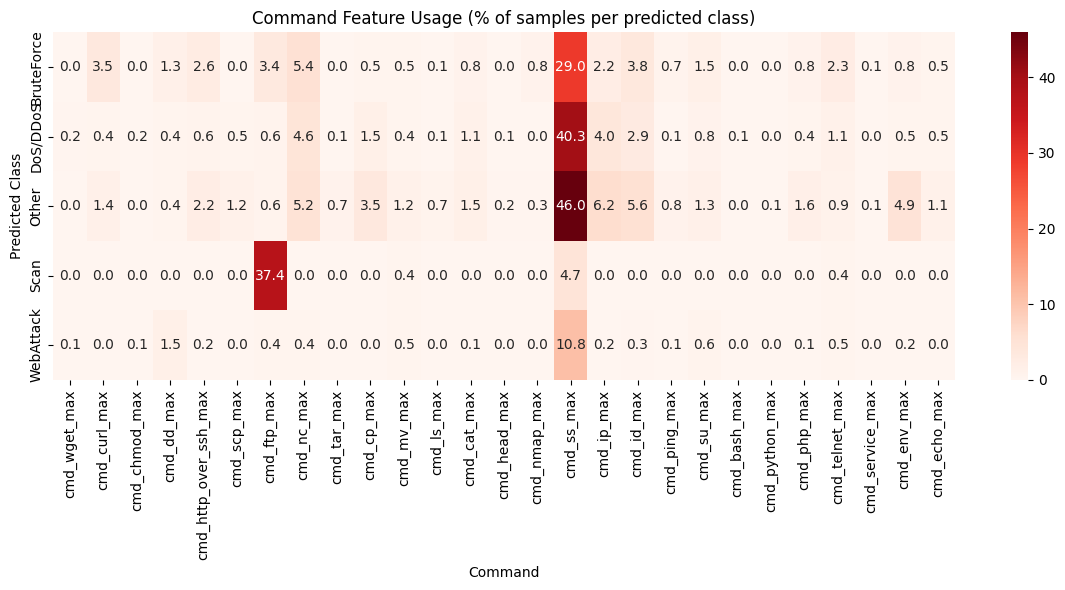

In [41]:
plt.figure(figsize=(12, 6))
sns.heatmap(binary_feature_means, annot=True, cmap="Reds", fmt=".1f")
plt.title("Command Feature Usage (% of samples per predicted class)")
plt.xlabel("Command")
plt.ylabel("Predicted Class")
plt.tight_layout()
plt.show()

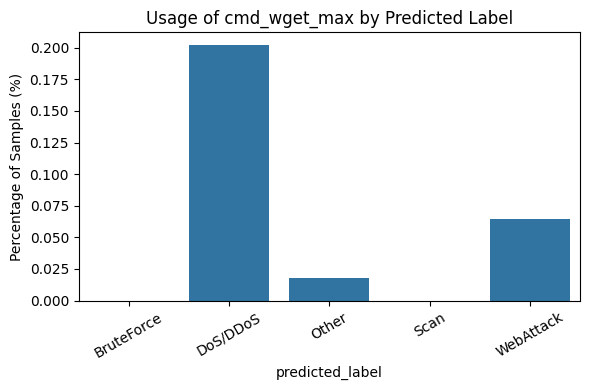

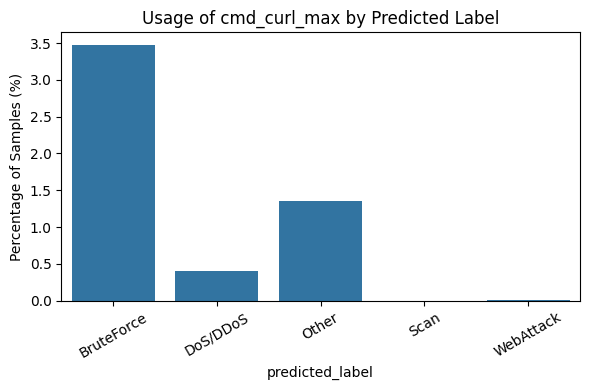

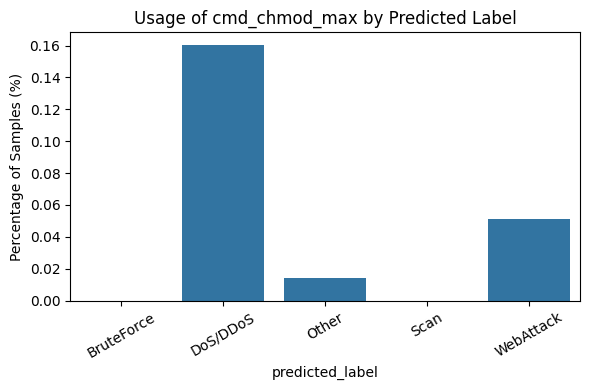

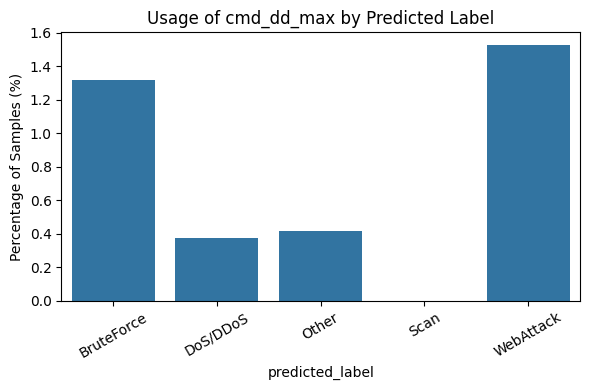

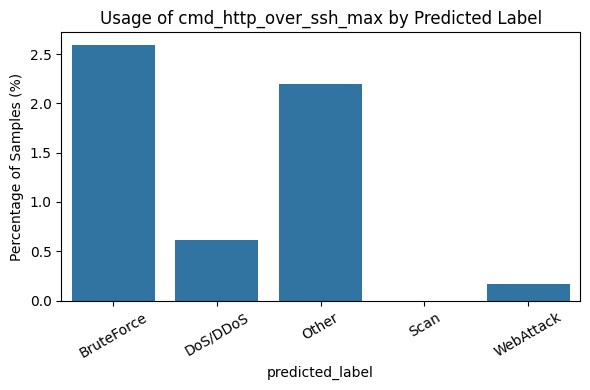

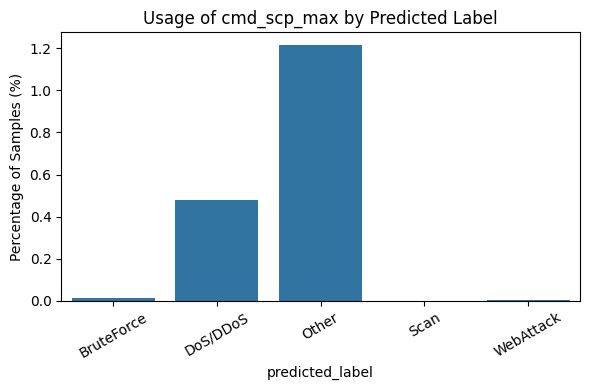

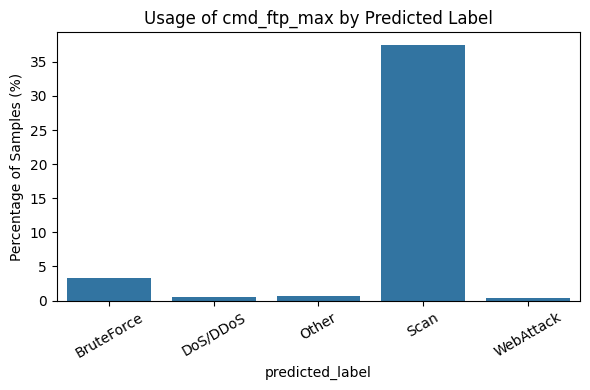

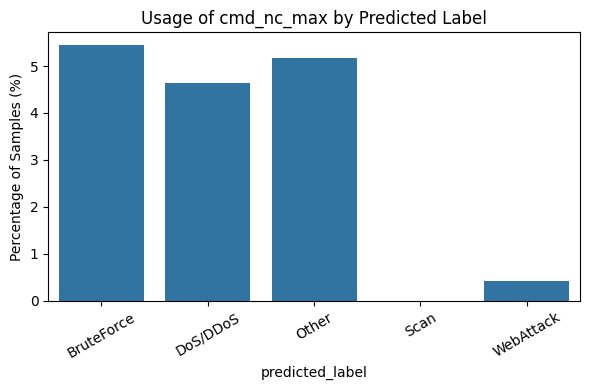

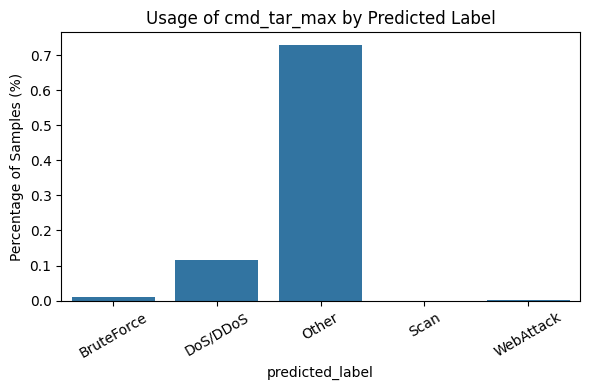

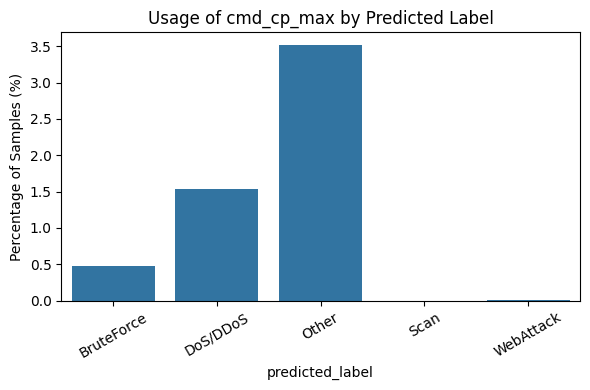

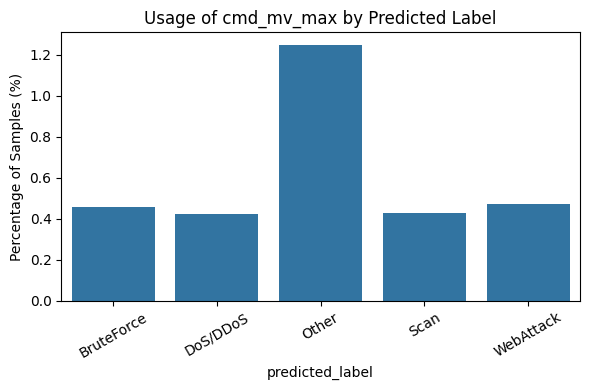

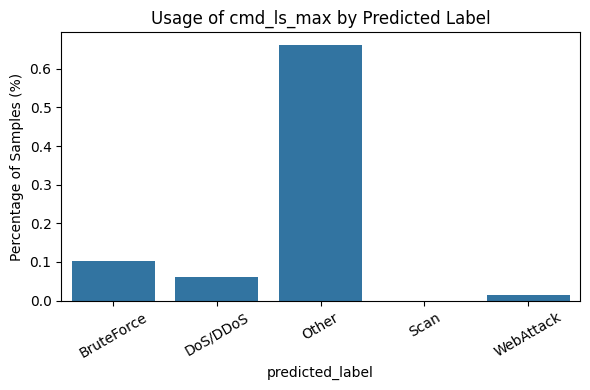

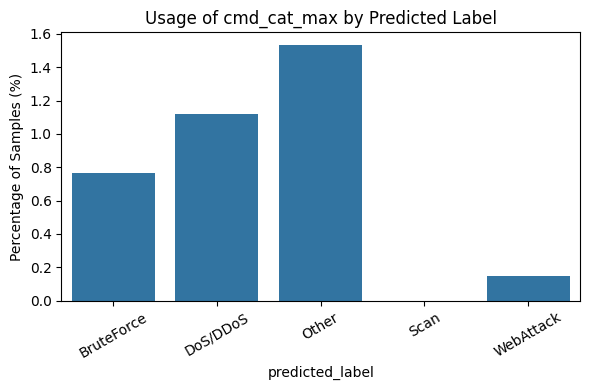

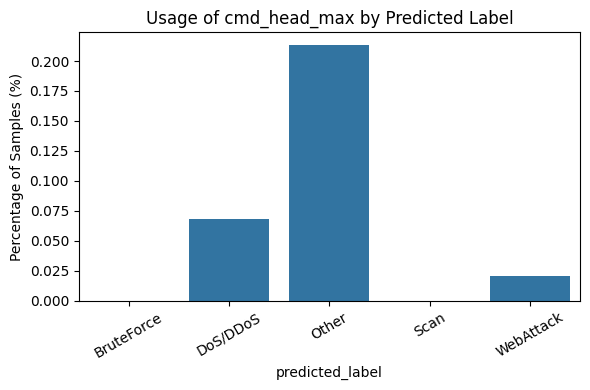

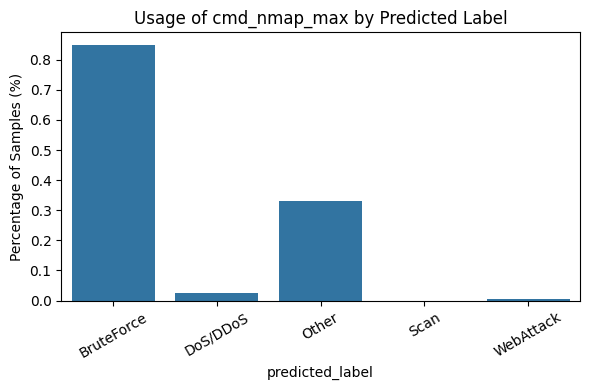

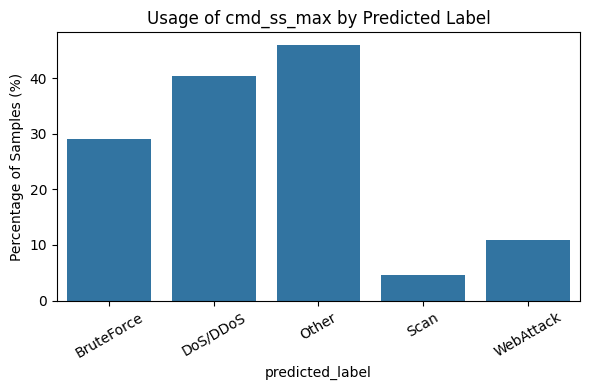

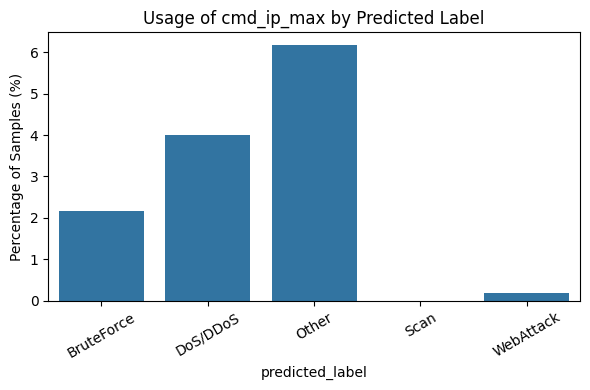

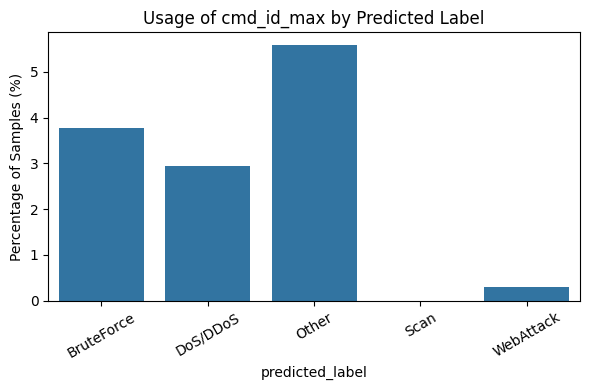

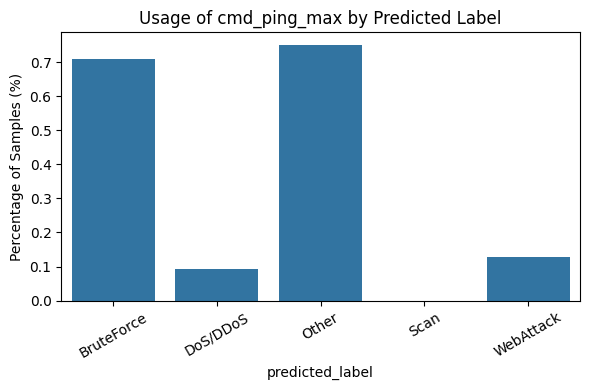

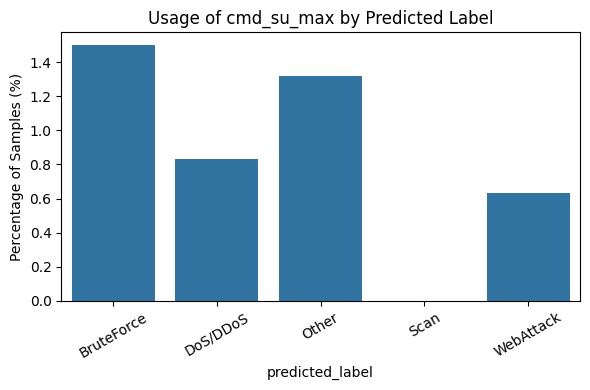

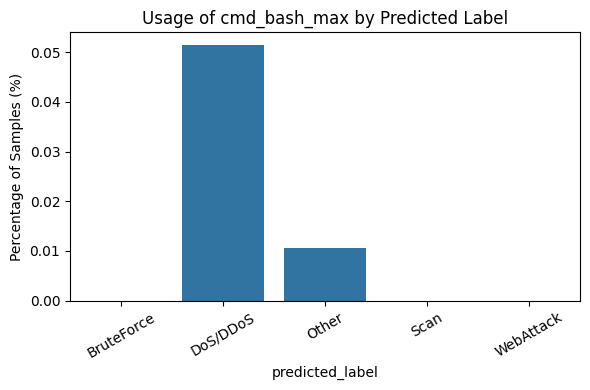

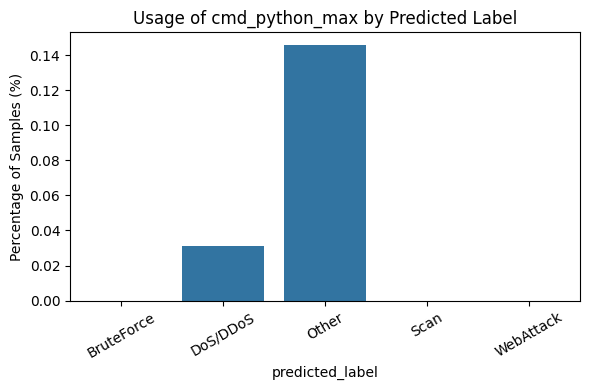

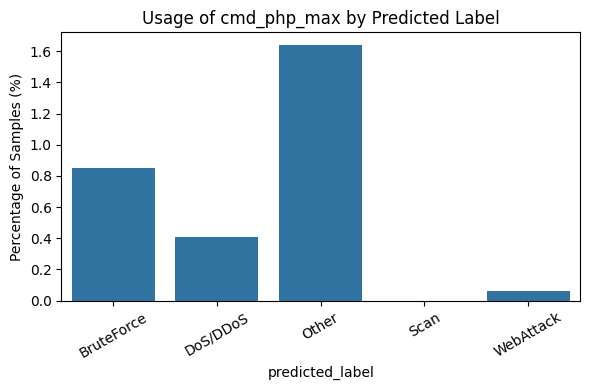

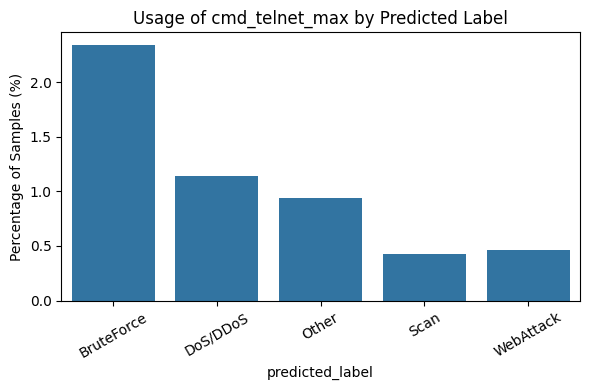

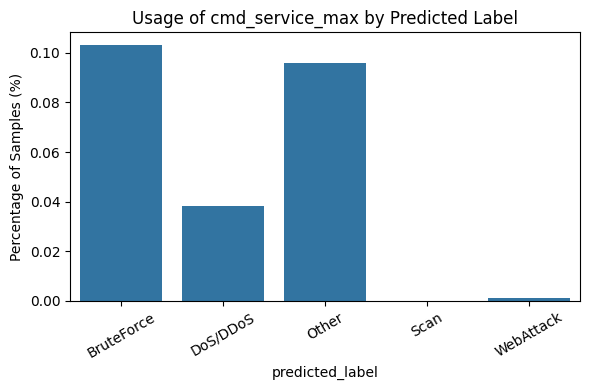

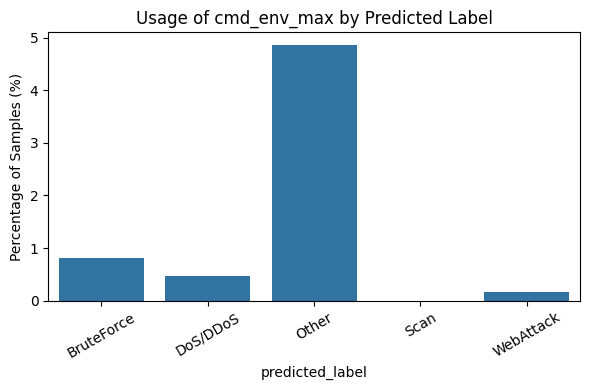

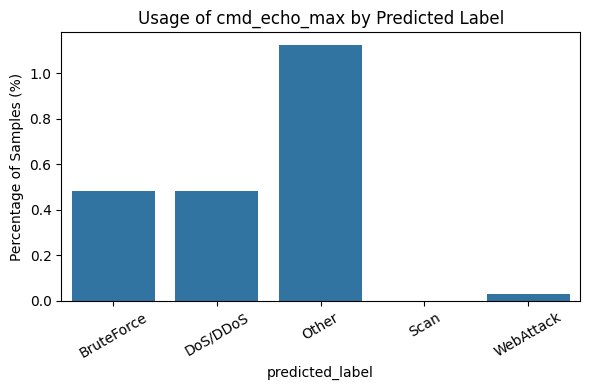

In [42]:
for feature in binary_feature_means.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=binary_feature_means.index, y=binary_feature_means[feature])
    plt.title(f"Usage of {feature} by Predicted Label")
    plt.ylabel("Percentage of Samples (%)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Model with high confidence predictions

combined the data from the previous model and the very high confidence predictions of the moni data (>0.97) to then retrain and see if there is an improvement in the performance

In [ ]:
# 1. Set a confidence threshold (e.g., 0.95)
confidence_threshold = 0.97

# 2. For each class, select high-confidence samples
high_conf_samples = []
high_conf_labels = []

for class_idx in range(omni_probs.shape[1]):
    # Find indices where predicted class == class_idx and confidence is high
    class_mask = (omni_pred == class_idx) & (omni_probs[:, class_idx] >= confidence_threshold)
    selected = x_grouped[class_mask]
    high_conf_samples.append(selected)
    high_conf_labels.extend([class_idx] * selected.shape[0])

# 3. Concatenate all high-confidence samples
if high_conf_samples:
    x_high_conf = pd.concat(high_conf_samples, axis=0)
    y_high_conf = np.array(high_conf_labels)
else:
    x_high_conf = pd.DataFrame()
    y_high_conf = np.array([])

print(f"Selected {len(y_high_conf)} high-confidence samples.")

# 4. Combine with your original training data
x_train_aug = pd.concat([x_train, x_high_conf], axis=0)
y_train_aug = np.concatenate([y_train, y_high_conf], axis=0)


Selected 169407 high-confidence samples.
